## Multilayer perceptron implementation using Pytorch and Torchvision library
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)

Author: Putama

In [263]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision as tv

import PIL
from PIL import Image

import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

import time

Populating the interactive namespace from numpy and matplotlib


In [143]:
# load the train images
# images are still in PIL image format
imgloader = tv.transforms.Compose([tv.transforms.ToTensor()])
imgunloader = tv.transforms.ToPILImage()
trainmnist = tv.datasets.MNIST('mnist/', train=True, download=True, transform=imgloader)
testmnist = tv.datasets.MNIST('mnist/', train=False, download=True, transform=imgloader)

# torch convenient tools to load manage dataset
batch_size = 100
trainloader = torch.utils.data.DataLoader(trainmnist, batch_size=batch_size, num_workers=4)
testloader = torch.utils.data.DataLoader(testmnist, batch_size=batch_size, num_workers=4)

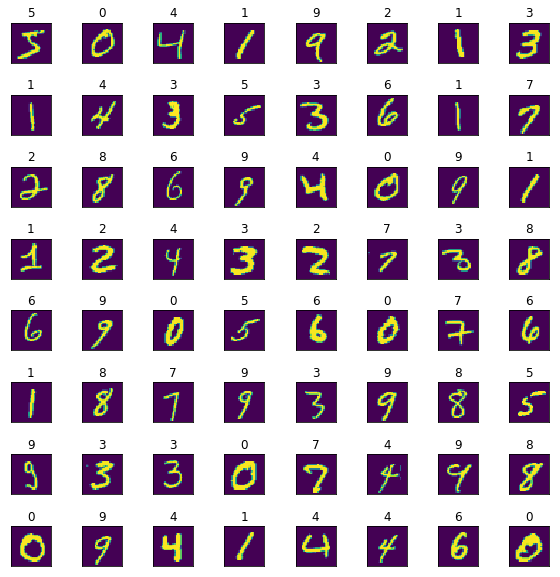

In [264]:
# visualize some of the first digit images
plt.subplots_adjust(hspace=.8)
for i in range(64):
    sbplt = plt.subplot(8,8,1+i)
    sbplt.set_title(trainmnist[i][1])
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    plt.imshow(imgunloader(trainmnist[i][0]))

In [140]:
# Training Parameters
learning_rate = 0.001
momentum = 0.9
training_epochs = 15
display_step = 1

# utilize cuda for computation
is_cuda = True

In [165]:
# define the architecture of the network
class MLP(nn.Module):
    def __init__(self, inp_dim):
        super(MLP, self).__init__()
        
        # layer size is arbitrarily defined
        self.inp_dim = inp_dim
        self.h1_size = 256
        self.h2_size = 256
        self.num_classes = 10
        
        self.layer1 = nn.Linear(self.inp_dim, self.h1_size)
        self.layer2 = nn.Linear(self.h1_size, self.h2_size)
        self.output_layer = nn.Linear(self.h2_size, self.num_classes)
        
    def forward(self, x):
        inp = x.view(-1, self.inp_dim)
        h1 = F.relu(self.layer1(inp))
        h2 = F.relu(self.layer2(h1))
        out = self.output_layer(h2)
        
        return out
    
# declare the network instant
datadim = trainmnist[0][0].size(1) * trainmnist[0][0].size(2)
net = MLP(datadim)

if is_cuda:
    net = net.cuda()

# define the loss function and the optimizer
# here we use common classification loss function: cross-entropy
criterion = nn.CrossEntropyLoss()
# we use stochastic gradient descent optimization
optimizer = th.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [172]:
# start training the network
for epoch in range(training_epochs):
    training_loss = 0.0
    starttime = time.time()
    
    for i, data in enumerate(trainloader, 0):
        # unpack the features and the labels
        features, labels = data
        
        # wrap them in Variable
        if is_cuda:
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
        else:
            features, labels = Variable(features), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # feed forward the batch to the network and compute the loss
        output = net(features)
        loss = criterion(output, labels)
        
        # compute the gradients and update the weights
        loss.backward()
        optimizer.step()
        
        training_loss += loss.data[0]
        
    # report progress of loss of each epoch
    print ('[epoch: %d] loss: %.3f, elapsed time: %.2f' % 
        (epoch+1, training_loss / (i+1), time.time() - starttime))

[epoch: 1] loss: 0.215, elapsed time: 2.78
[epoch: 2] loss: 0.207, elapsed time: 2.92
[epoch: 3] loss: 0.200, elapsed time: 3.21
[epoch: 4] loss: 0.193, elapsed time: 2.80
[epoch: 5] loss: 0.186, elapsed time: 2.85
[epoch: 6] loss: 0.180, elapsed time: 2.86
[epoch: 7] loss: 0.174, elapsed time: 3.38
[epoch: 8] loss: 0.168, elapsed time: 2.81
[epoch: 9] loss: 0.163, elapsed time: 2.86
[epoch: 10] loss: 0.158, elapsed time: 2.87
[epoch: 11] loss: 0.153, elapsed time: 2.82
[epoch: 12] loss: 0.148, elapsed time: 2.76
[epoch: 13] loss: 0.144, elapsed time: 2.79
[epoch: 14] loss: 0.139, elapsed time: 2.90
[epoch: 15] loss: 0.135, elapsed time: 2.80


In [208]:
# measure the performance on test data
correct = 0
total = 0

mispredicted = []

for data in testloader:
    # unpack the features and the labels
    features, labels = data
    
    # wrap them in Variable
    if is_cuda:
        features, labels = Variable(features.cuda()), labels.cuda()
    else:
        features = Variable(features)
        
    # feed forward the batch to the network and take the max
    output = net(features)
    _, predicted = torch.max(output.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
    # record misclassified data
    for i in range(len(predicted)):
        if not predicted[i].cpu().numpy()[0] == labels[i]:
            mispredicted.append((features[i], labels[i], predicted[i]))
    
print ('Test accuracy: %.1f%%' % (100 * correct / total))

Test accuracy: 95.0%


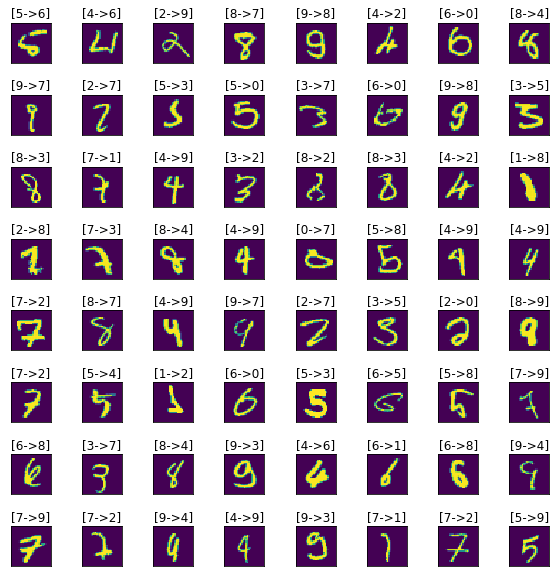

In [258]:
# visualized the first 64 mistakes
# the format of the title [correct label] -> [predicted label]
plt.subplots_adjust(hspace=.8)
for i in range(64):
    sbplt = plt.subplot(8,8,1+i)
    sbplt.set_title('[' + str(mispredicted[i][1]) + '->' +
                    str(mispredicted[i][2].cpu().numpy()[0]) + ']') 
    sbplt.get_xaxis().set_visible(False)
    sbplt.get_yaxis().set_visible(False)
    sbplt.imshow(imgunloader(mispredicted[i][0].data.cpu()))